In [1]:
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import torch.autograd      as autograd

import numpy as np
import matplotlib.pyplot   as plt

from scipy.integrate import odeint

import abc

In [2]:
def diff(x, t, order=1):
    ones = torch.ones_like(t)
    der, = autograd.grad(x, t, create_graph=True, grad_outputs=ones)
    for i in range(1, order):
        der, = autograd.grad(der, t, create_graph=True, grad_outputs=ones)
    return der

In [3]:
class FCNN(nn.Module):
    """
    A fully connected neural network.
    """
    def __init__(self, n_hidden_units, n_hidden_layers, actv):
        """
        :param n_hidden_units: number of hidden units in each hidden layer
        :param n_hidden_layers: number of hidden layers
        :param actv: the activation layer used in each hidden layer
        """
        super(FCNN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(1, n_hidden_units))
        layers.append(actv())
        for i in range(n_hidden_layers):
            layers.append(nn.Linear(n_hidden_units, n_hidden_units))
            layers.append(actv())
        layers.append(nn.Linear(n_hidden_units, 1))
        self.NN = torch.nn.Sequential(*layers)

    def forward(self, t):
        x = self.NN(t)
        return x

In [4]:
class Condition:
    def __init__(self):
        pass
    @abc.abstractmethod
    def enforce(self, t, x):
        pass
    
class InitialValueProblem(Condition):
    """
    A initial value problem: 
    x (t=t_0) = x_0
    x'(t=t_0) = x_0_prime
    """
    def __init__(self, t_0, x_0, x_0_prime=None):
        self.t_0, self.x_0, self.x_0_prime = t_0, x_0, x_0_prime
    def enforce(self, t, x):
        if self.x_0_prime: 
            return self.x_0 + (1-torch.exp(-t+self.t_0))*self.x_0_prime + ( (1-torch.exp(-t+self.t_0))**2 )*x
        else:
            return self.x_0 + (1-torch.exp(-t+self.t_0))*x

class TwoPointDirichletBoundaryCondition(Condition):
    """
    A two point Dirichlet boundary condition: 
    x(t=t_0) = x_0
    x(t=t_0) = x_1
    """
    def __init__(self, t_0, x_0, t_1, x_1):
        self.t_0, self.x_0, self.t_1, self.x_1 = t_0, x_0, t_1, x_1
    def enforce(self, t, x):
        t_tilde = (t-self.t_0) / (self.t_1-self.t_0)
        return self.x_0*(1-t_tilde) + self.x_1*t_tilde + (1-torch.exp((1-t_tilde)*t_tilde))*x

In [5]:
class ExampleGenerator:
    def __init__(self, size, t_min=0.0, t_max=1.0, method='uniform'):
        self.size = size
        self.t_min, self.t_max = t_min, t_max
        if   method=='uniform':
            self.examples = torch.zeros(self.size, requires_grad=True)
            self.get_examples = lambda: self.examples + torch.rand(self.size)*(self.t_max-self.t_min) + self.t_min
        elif method=='equally-spaced':
            self.examples = torch.linspace(self.t_min, self.t_max, self.size, requires_grad=True)
            self.get_examples = lambda: self.examples
        elif method=='equally-spaced-noisy':
            self.examples = torch.linspace(self.t_min, self.t_max, self.size, requires_grad=True)
            self.noise_mean = torch.zeros(self.size)
            self.noise_std  = torch.ones(self.size) * ( (t_max-t_min)/size ) / 4.0
            self.get_examples = lambda: self.examples + torch.normal(mean=self.noise_mean, std=self.noise_std)
        else:
            raise ValueError(f'Unknown method: {method}')

In [6]:
class Monitor:
    def __init__(self, t_min, t_max, check_every=100):
        %matplotlib notebook
        self.check_every = check_every
        self.fig = plt.figure(figsize=(20, 8))
        self.ax1 = self.fig.add_subplot(121)
        self.ax2 = self.fig.add_subplot(122)
        # input for plotting
        self.ts_plt =    np.linspace(t_min, t_max, 100) 
        # input for neural network
        self.ts_ann = torch.linspace(t_min, t_max, 100, requires_grad=True).reshape((-1, 1, 1)) 
    def check(self, nets, ode_system, conditions, loss_history):
        n_dependent = len(conditions)
    
        vs = []
        for i in range(n_dependent):
            v_i = nets[i](self.ts_ann)
            if conditions[i]: v_i = conditions[i].enforce(self.ts_ann, v_i)
            vs.append(v_i.detach().numpy().flatten())

        self.ax1.clear()
        for i in range(n_dependent):
            self.ax1.plot(self.ts_plt, vs[i], label=f'variable {i}')
        self.ax1.legend()
        self.ax1.set_title('solutions')

        self.ax2.clear()
        self.ax2.plot(loss_history)
        self.ax2.set_title('loss during training')
        self.ax2.set_ylabel('loss')
        self.ax2.set_xlabel('epochs')
        self.ax2.set_yscale('log')

        self.fig.canvas.draw()

In [7]:
def solve_system(ode_system, conditions, t_min, t_max,
          nets=None, example_generator=None, optimizer=None, criterion=None, batch_size=16, 
          max_epochs=100000, tol=1e-4,
          monitor=None):
    """
    Train a neural network to solve an ODE.
    
    :param ode: an ode to be solved, it should be a function (x, t) -> F(x, t)
    :param condition: the initial value/boundary condition, a Condition instance
    :param net: a pytorch neural network, a nn.Module instance
    :param t_min: lower bound of the domain on which the ode is solved
    :param t_max: upper bound of the domain on which the ode is solved
    :param example_generator: a ExampleGenerator instance
    :param optimizer: a optimizer from pytorch.optim
    :param criterion: a loss function from pytorch.nn
    :param batch_size: the size of the minibatch
    :param max_epochs: the maximum number of epochs
    :param tol: the training stops if the loss is lower than this value
    :param monitor: a Monitor instance
    """
    
    # default values
    n_dependent_vars = len(conditions)
    if not nets: 
        nets = [FCNN(n_hidden_units=32, n_hidden_layers=1, actv=nn.Tanh)
                for _ in range(n_dependent_vars)]
    if not example_generator: 
        example_generator = ExampleGenerator(32, t_min, t_max, method='equally-spaced-noisy')
    if not optimizer:
        all_parameters = []
        for net in nets: all_parameters += list(net.parameters())
        optimizer = optim.Adam(all_parameters, lr=0.001)
    if not criterion:
        criterion = nn.MSELoss()
    if not monitor:
        monitor = Monitor(t_min, t_max, check_every=100)
    
    n_examples = example_generator.size
    if n_examples%batch_size != 0:
        # todo: I know this is stupid, I'll fix this later
        raise RuntimeError('Please choose a batch_size such that it is a factor of the size of the training set.')
    n_batches = n_examples//batch_size
    zeros = torch.zeros(batch_size)
    
    loss_history = []
    
    for epoch in range(max_epochs):
        loss_epoch = 0.0

        examples = example_generator.get_examples()
        ts_batches = examples.reshape((n_batches, batch_size, 1))
        for ts in ts_batches:     

            # the dependent variables
            vs = []
            for i in range(n_dependent_vars):
                v_i = nets[i](ts)
                if conditions[i]: v_i = conditions[i].enforce(ts, v_i)
                vs.append(v_i)
            
            Fvts = ode_system(*vs, ts)
            loss = 0.0
            for Fvt in Fvts: loss += criterion(Fvt, zeros)
            loss_epoch += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_history.append(loss_epoch/n_batches)
        if loss_history[-1] < tol: break
        
        if epoch%monitor.check_every == 0:
            monitor.check(nets, ode_system, conditions, loss_history)
    
    def solution(ts):
        if not isinstance(ts, torch.Tensor): ts = torch.tensor([ts], dtype=torch.float32)
        ts = ts.reshape(-1, 1)
        results = []
        for i in range(len(conditions)):
            xs = nets[i](ts)
            xs = conditions[i].enforce(ts, xs)
            results.append( xs.detach().numpy() )
        return results
    if loss_history[-1] > tol:
        print('The solution has not converged.')
        
    return solution, loss_history

Let $x_1 = y$ and $x_2 = y^{'}$ The equation $y^{''} + y = 0, 0 < t < 2\pi$ can be written as

$$\begin{align}
x_1^{'} - x_2 &= 0 \\
x_2^{'} + x_1 &= 0
\end{align}$$

Let $x_1(0) = 0, x_2(0) = 1$, the solution should be $x_1 = \sin(t), x_2 = \cos(t)$

<IPython.core.display.Javascript object>


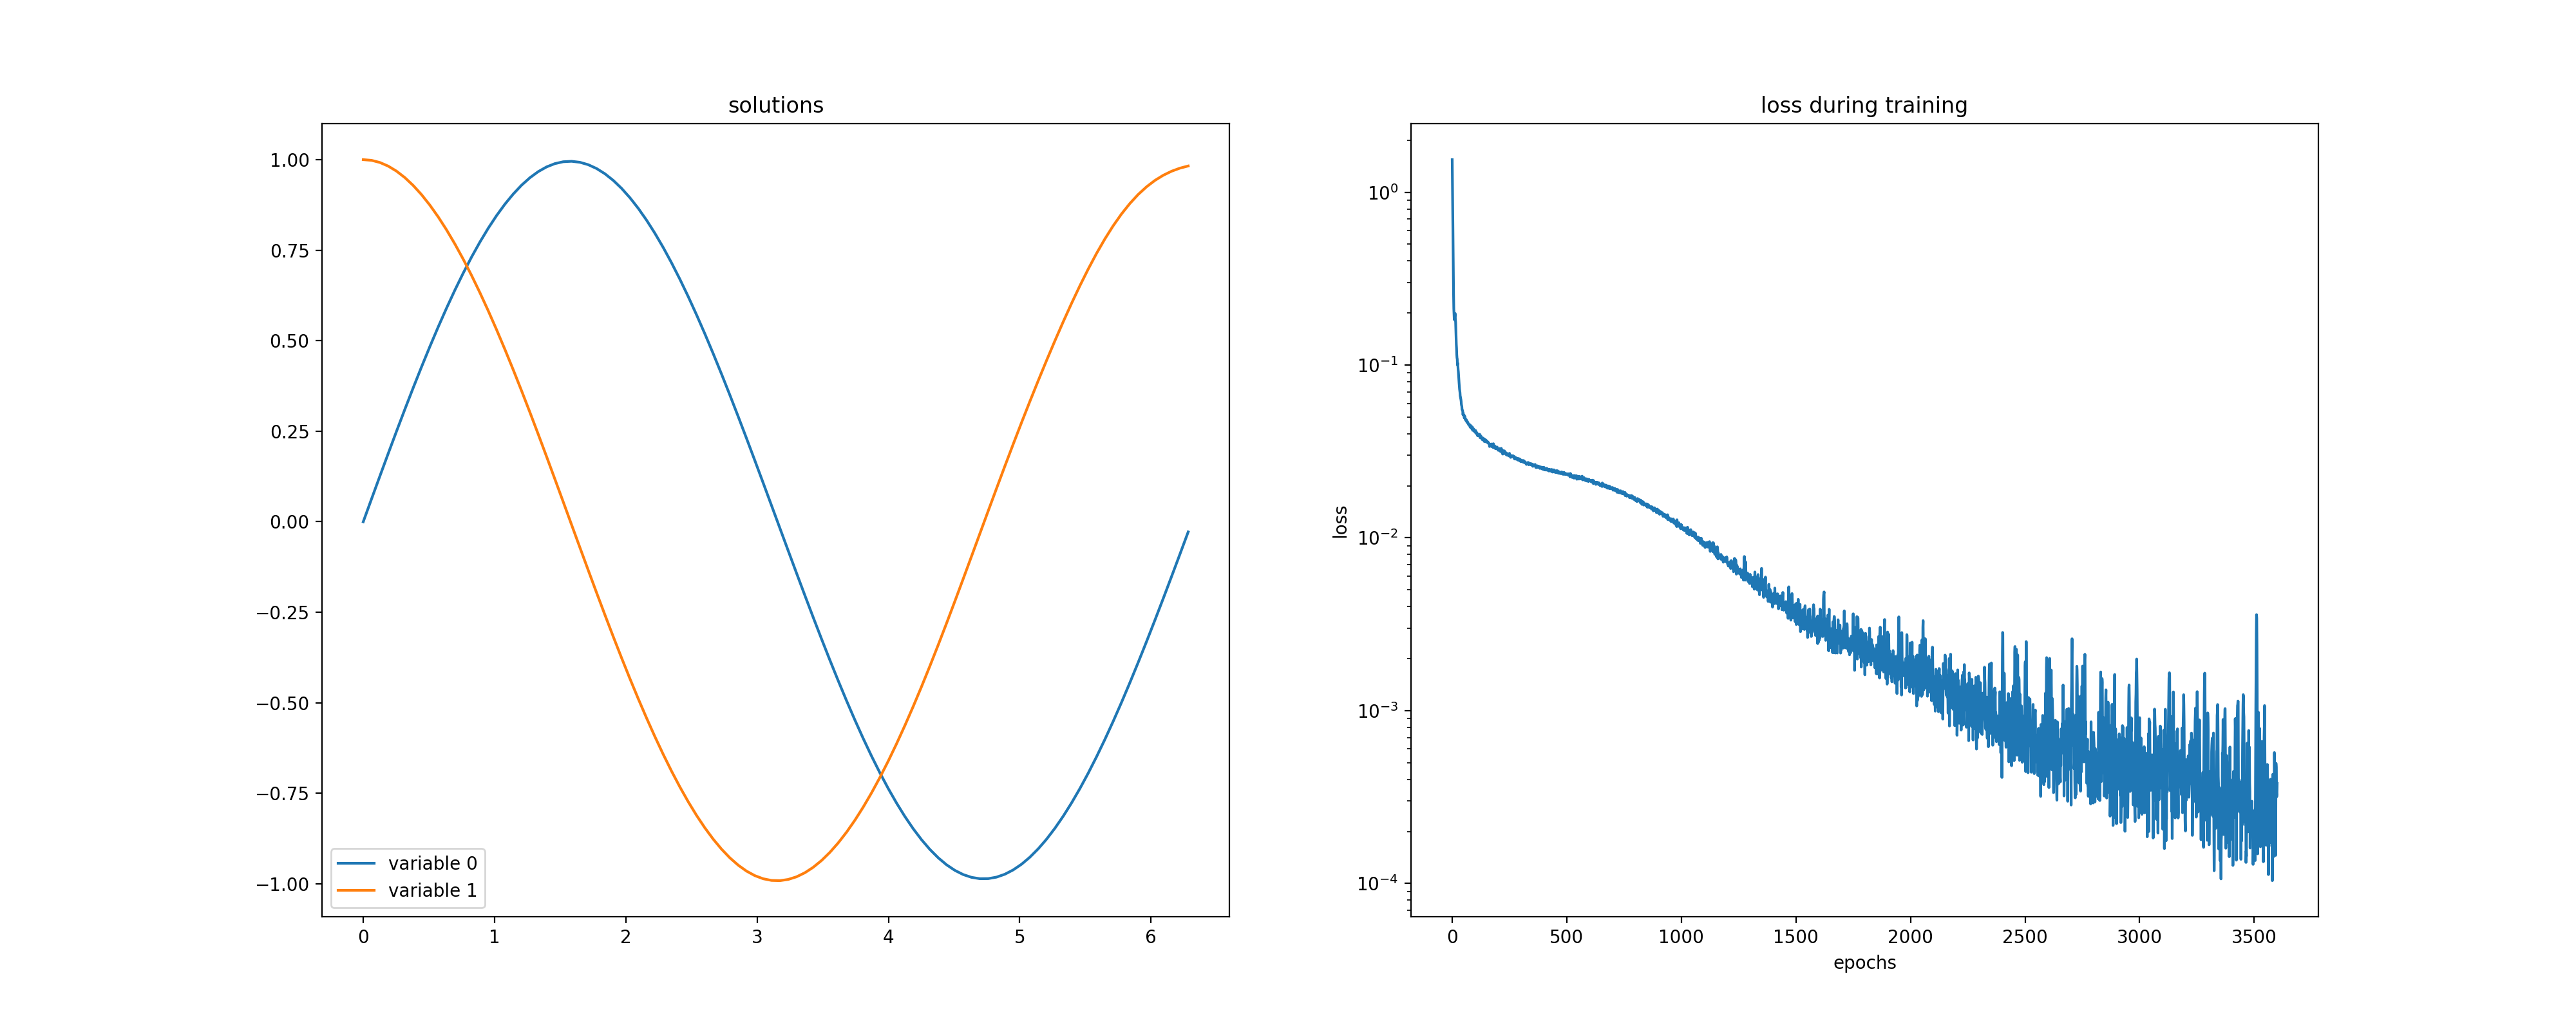

In [8]:
parametric_circle = lambda x1, x2, t : [diff(x1, t) - x2, 
                                        diff(x2, t) + x1]
init_vals_pc = [
    InitialValueProblem(t_0=0.0, x_0=0.0),
    InitialValueProblem(t_0=0.0, x_0=1.0)
]
solution_pc, _ = solve_system(ode_system=parametric_circle, conditions=init_vals_pc, t_min=0.0, t_max=2*np.pi)

<IPython.core.display.Javascript object>


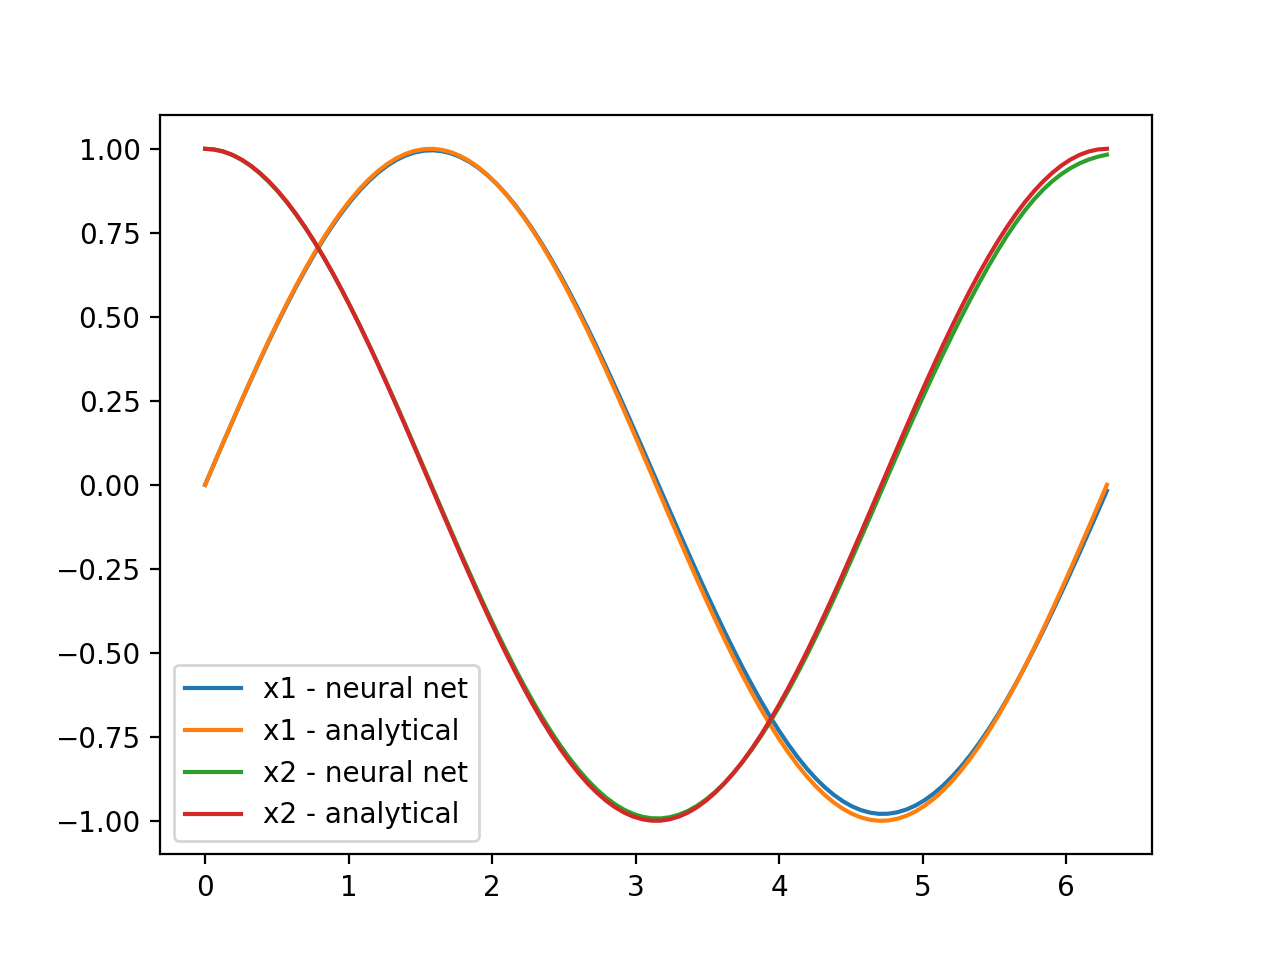

In [9]:
ts = np.linspace(0, 2*np.pi, 100)
sols_net = solution_pc(ts)
plt.plot(ts, sols_net[0], label='x1 - neural net')
plt.plot(ts, np.sin(ts),  label='x1 - analytical')
plt.plot(ts, sols_net[1], label='x2 - neural net')
plt.plot(ts, np.cos(ts),  label='x2 - analytical')
plt.legend()
plt.show()

For a simple chemical reaction:
$$
A + B \to C
$$
where the reaction coefficient is $k$.

Let the concentration of $A$ be $x_1$, the concentration of $B$ be $x_2$, the concentration of $C$ be $x_3$. We further assume that the initial concentration of $A$ and $B$ are the same, so they will stay the same during the whole reaction.

The reaction rate can be expressed as:
$$
\frac{dx_1}{dt} = -kx_1^2\\
\frac{dx_3}{dt} = kx_1^2
$$

If we start with $x_1 = x_{1, 0}, x_{3, 0} = 0.0$, the analytical solution of this system will be 
$$
x_1 = \frac{x_{1, 0}}{1+kx_{1, 0}t} \\
x_3 = x_{1, 0}+x_{3, 0}-\frac{x_{1, 0}}{1+kx_{1, 0}t}
$$

<IPython.core.display.Javascript object>


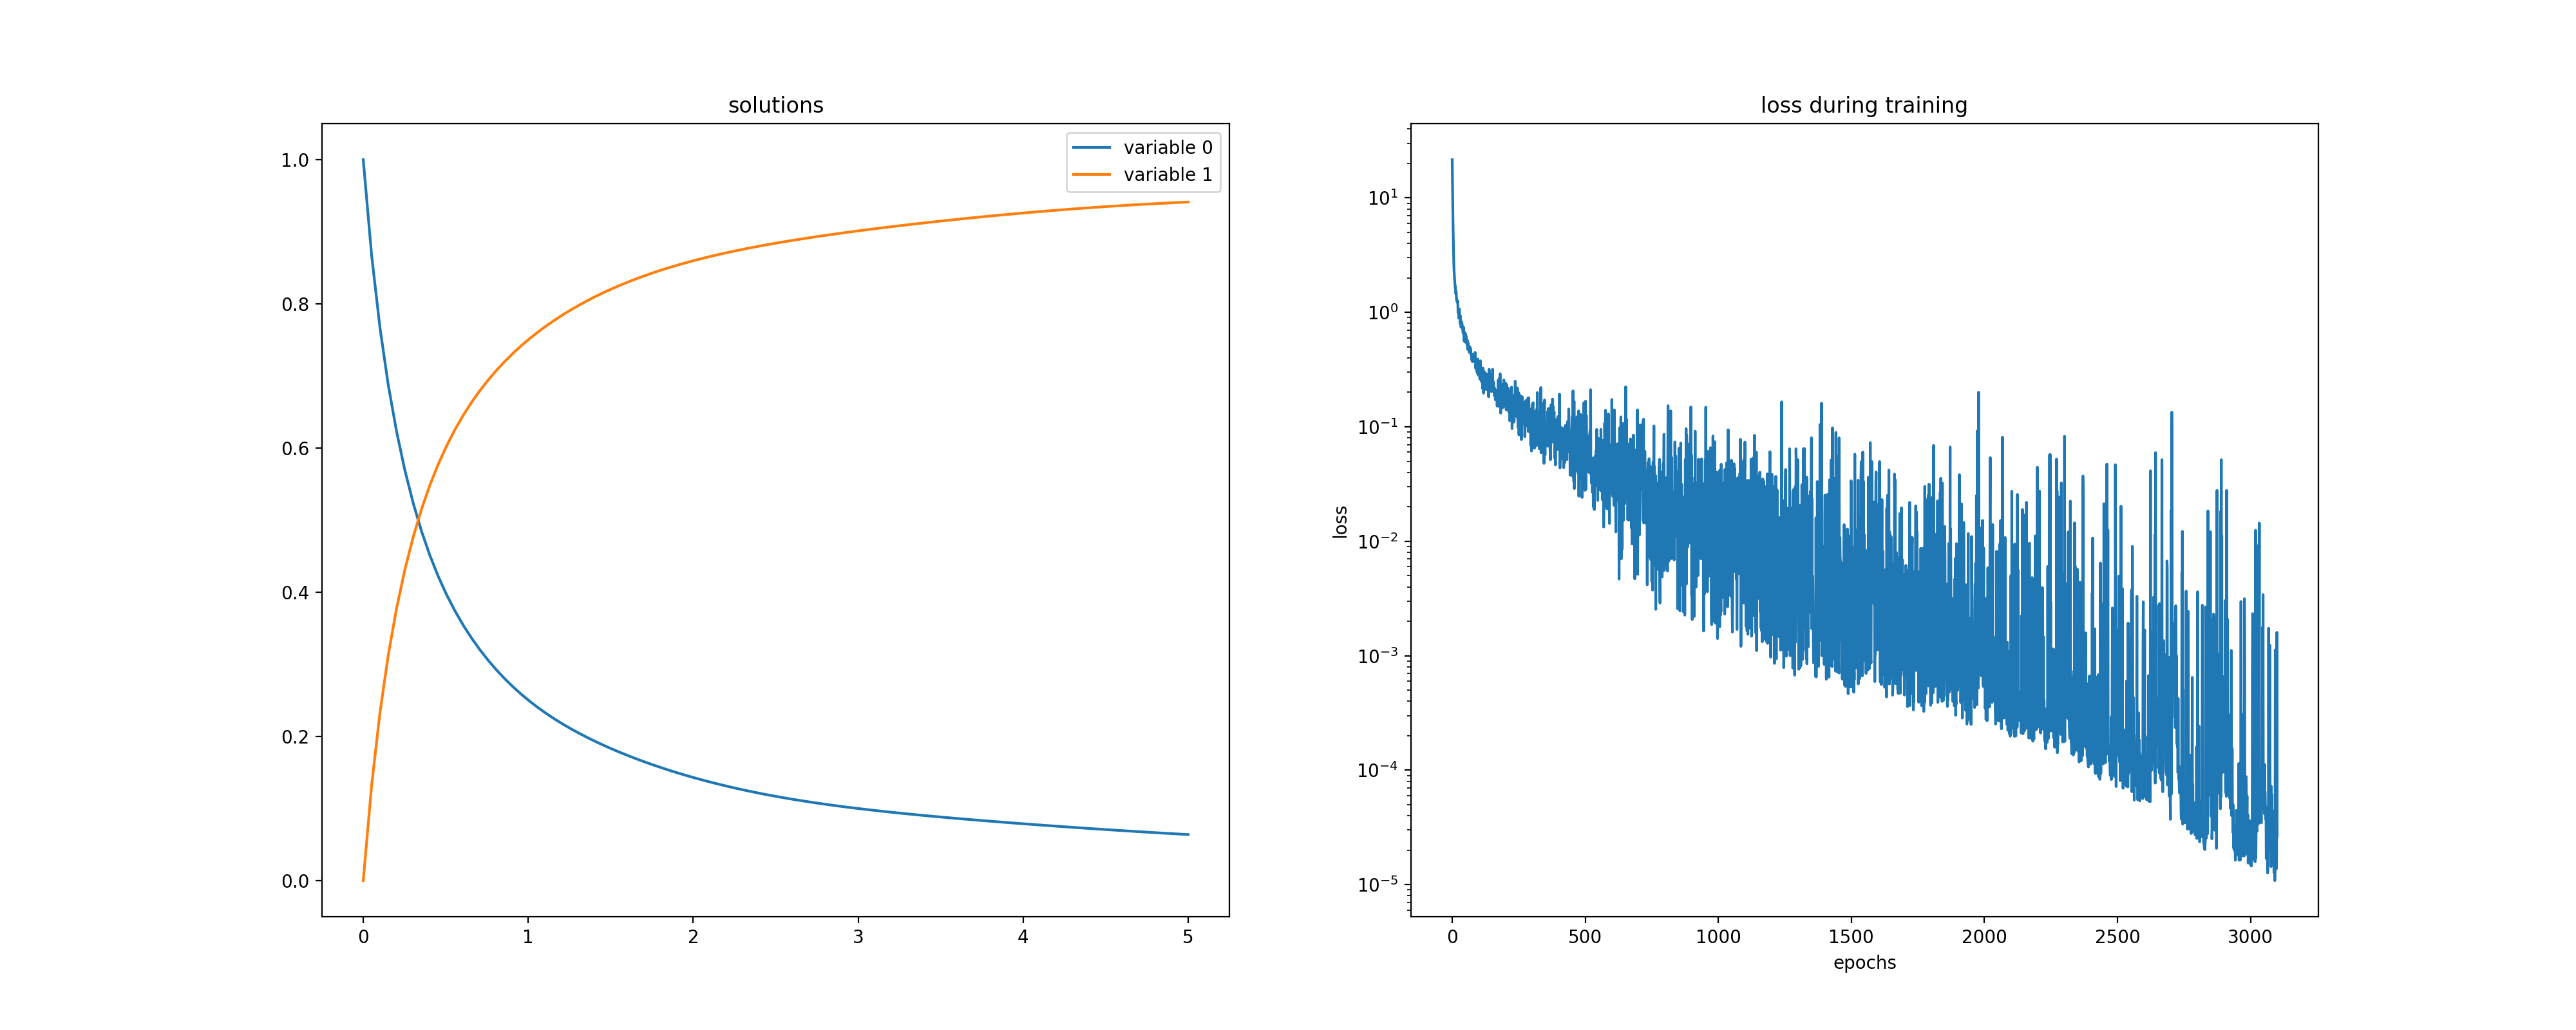

In [10]:
k = 3.0
x_10 = 1.0
x_30 = 0.0
chem_reac = lambda x1, x3, t : [diff(x1, t) + k*x1**2 , 
                                diff(x3, t) - k*x1**2]
init_vals_ce = [
    InitialValueProblem(t_0=0.0, x_0=x_10),
    InitialValueProblem(t_0=0.0, x_0=x_30)
]
solution_cr, _ = solve_system(ode_system=chem_reac, conditions=init_vals_ce, t_min=0.0, t_max=5.0,
                              tol=1e-5)

<IPython.core.display.Javascript object>


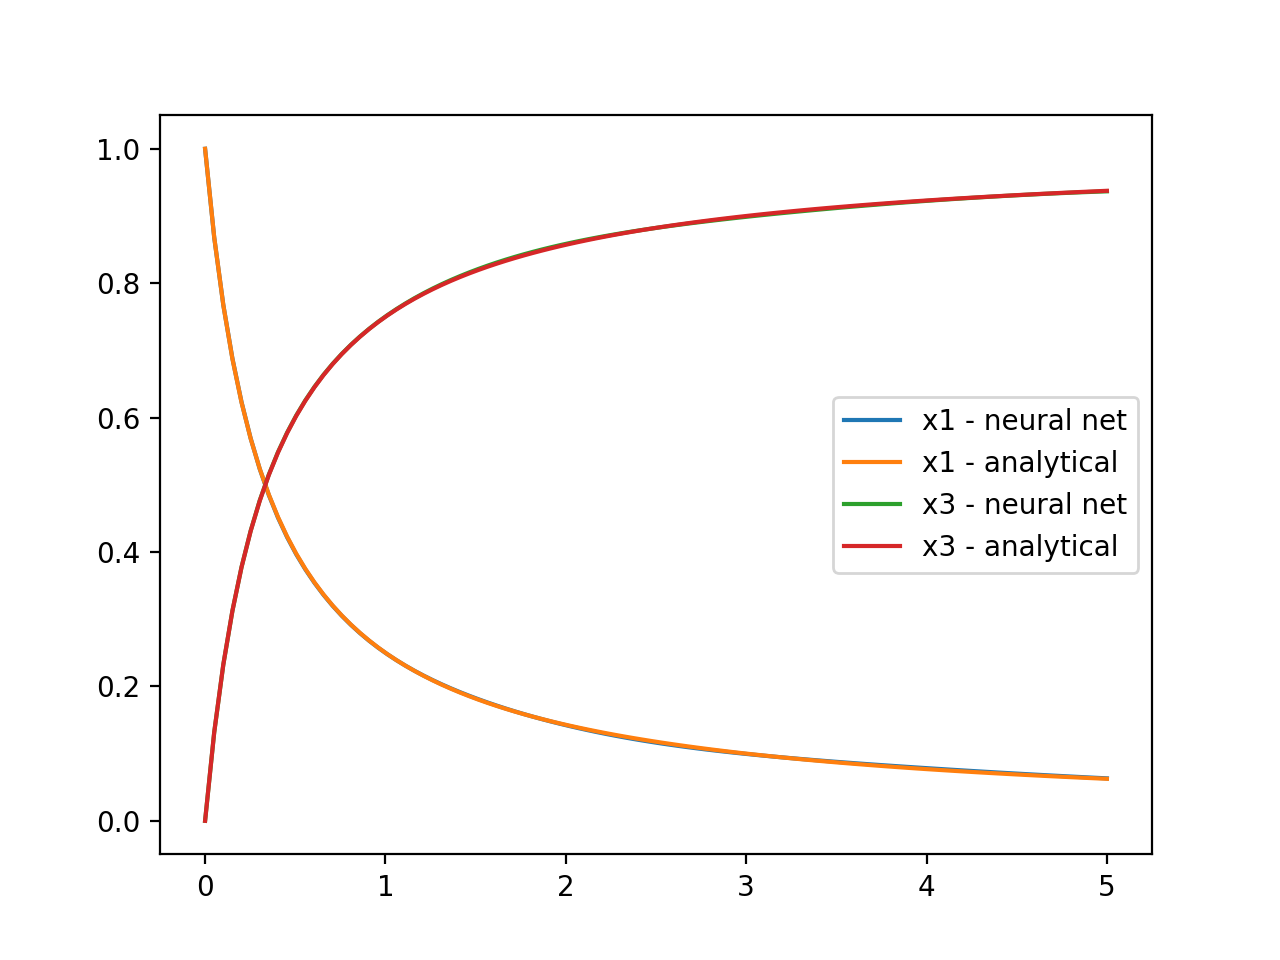

In [11]:
ts = np.linspace(0, 5.0, 100)
sols_net = solution_cr(ts)
plt.plot(ts, sols_net[0], label='x1 - neural net')
plt.plot(ts,               x_10 / (1+k*x_10*ts),  label='x1 - analytical')
plt.plot(ts, sols_net[1], label='x3 - neural net')
plt.plot(ts, x_10 + x_30 - x_10 / (1+k*x_10*ts),  label='x3 - analytical')
plt.legend()
plt.show()

Lotka–Volterra equations are a pair of nonlinear ODE frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey:

$$\begin{align}
\frac{dx}{dt} = \alpha x - \beta xy \\
\frac{dy}{dt} = \delta xy - \gamma y
\end{align}$$

Let $\alpha = \beta = \delta = \gamma = 1$. Here we solve this pair of ODE when $x(0) = 1.5$ and $y(0) = 1.0$.

The numerical solution:

<IPython.core.display.Javascript object>


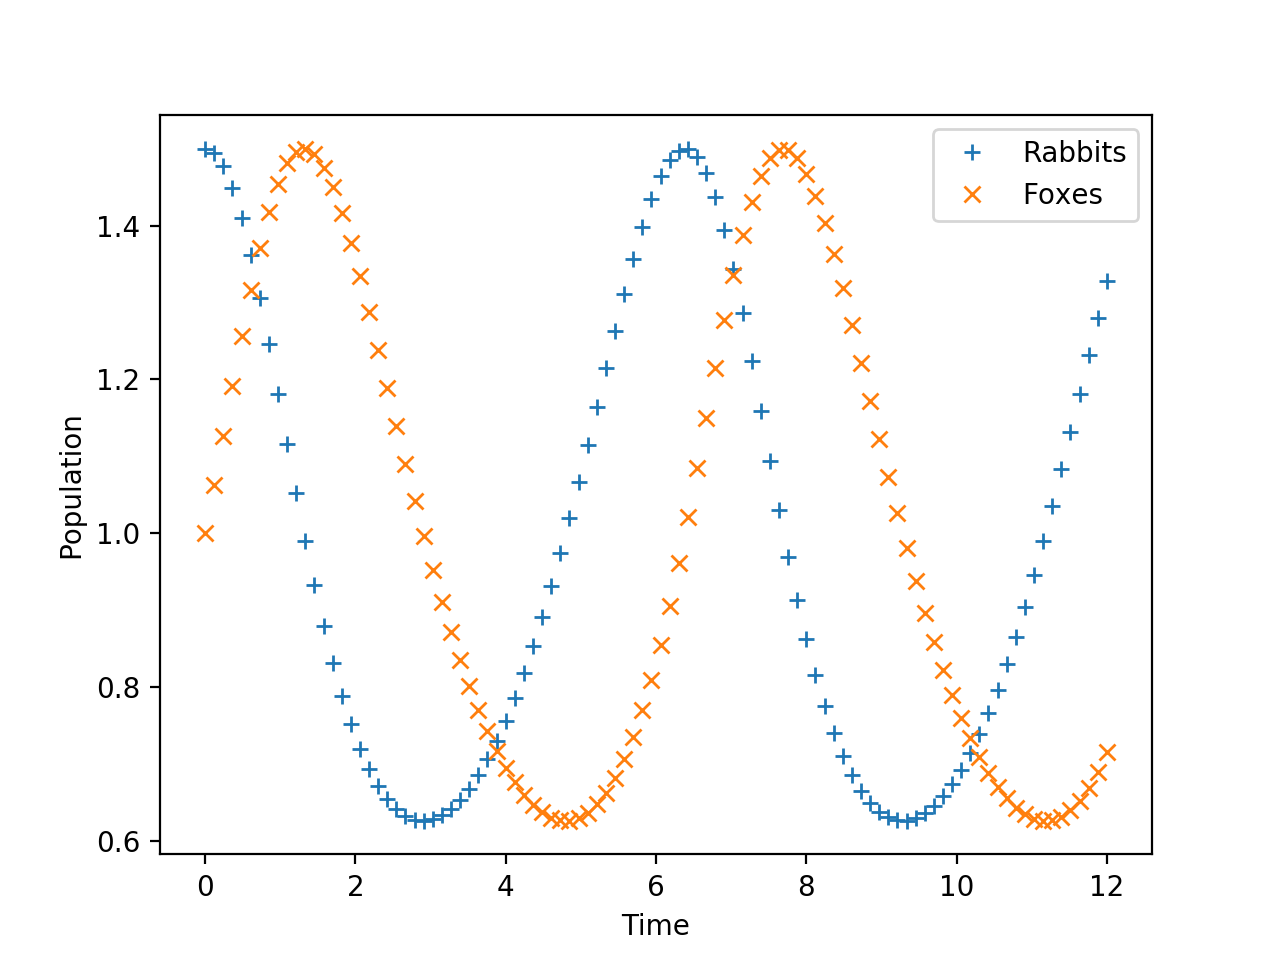

In [12]:
# from http://sam-dolan.staff.shef.ac.uk/mas212/notebooks/ODE_Example.html

alpha, beta, delta, gamma = 1, 1, 1, 1

def dP_dt(P, t):
    return [P[0]*alpha - beta*P[0]*P[1], delta*P[0]*P[1] - gamma*P[1]]

ts = np.linspace(0, 12, 100)
P0 = [1.5, 1.0]
Ps = odeint(dP_dt, P0, ts)
prey = Ps[:,0]
predators = Ps[:,1]

plt.plot(ts, prey, "+", label="Rabbits")
plt.plot(ts, predators, "x", label="Foxes")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


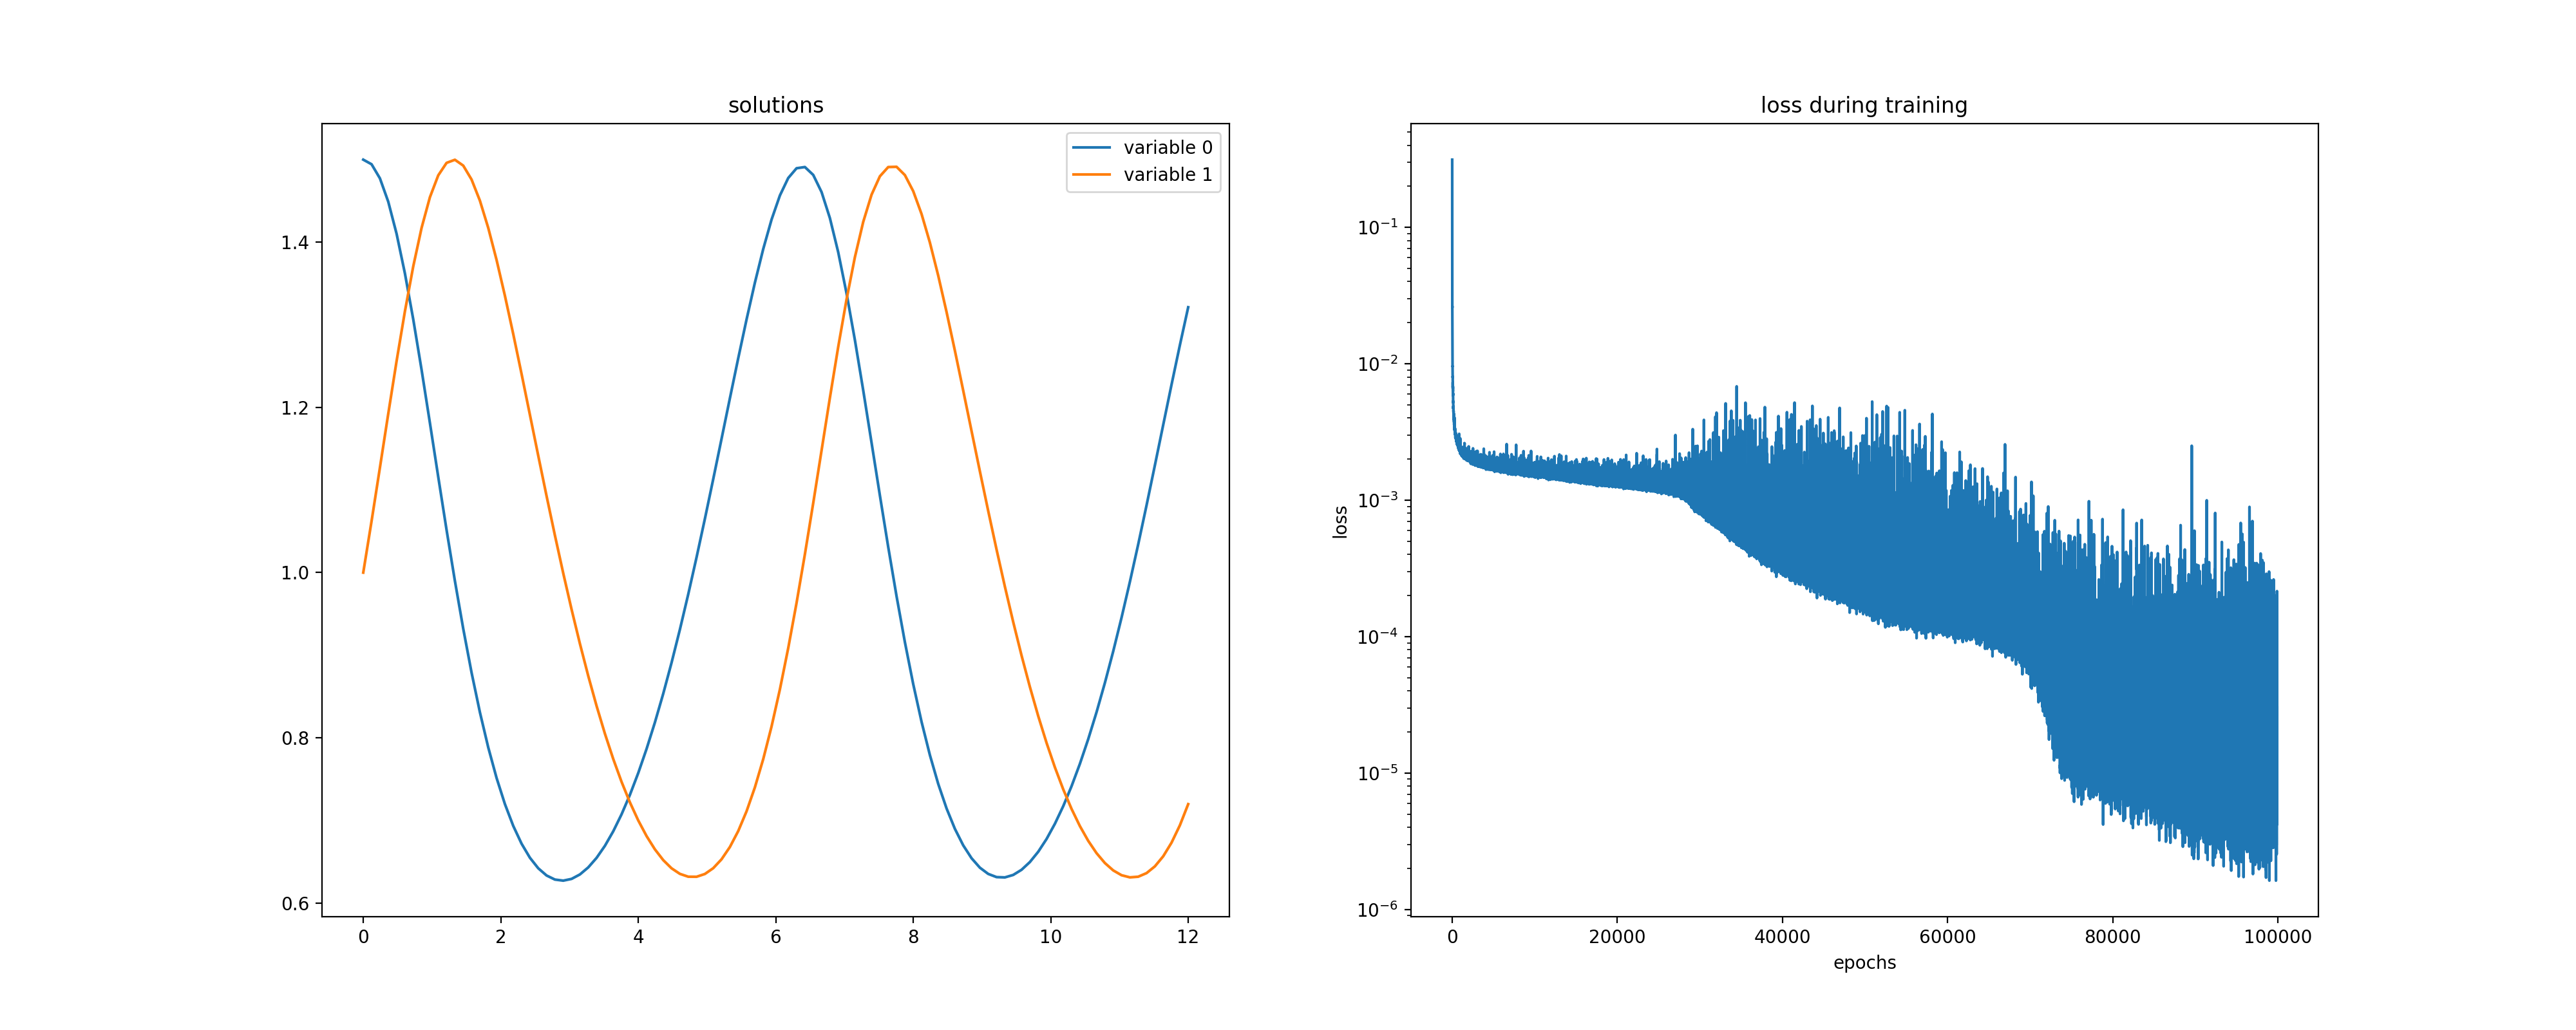

The solution has not converged.


In [13]:
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda x, y, t : [diff(x, t) - (alpha*x   - beta*x*y), 
                                   diff(y, t) - (delta*x*y - gamma*y)]
init_vals_lv = [
    InitialValueProblem(t_0=0.0, x_0=1.5),
    InitialValueProblem(t_0=0.0, x_0=1.0)
]
_, _ = solve_system(ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12,
                    tol=1e-6)

The neural net is still having the same old optimizing plateau problem with oscillating solutions. However, if we know in advance that the solution will be periodical, we can use sin as activation function, which resulted in much faster convergence.

In [14]:
class SinActv(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input_):
        return torch.sin(input_)

<IPython.core.display.Javascript object>


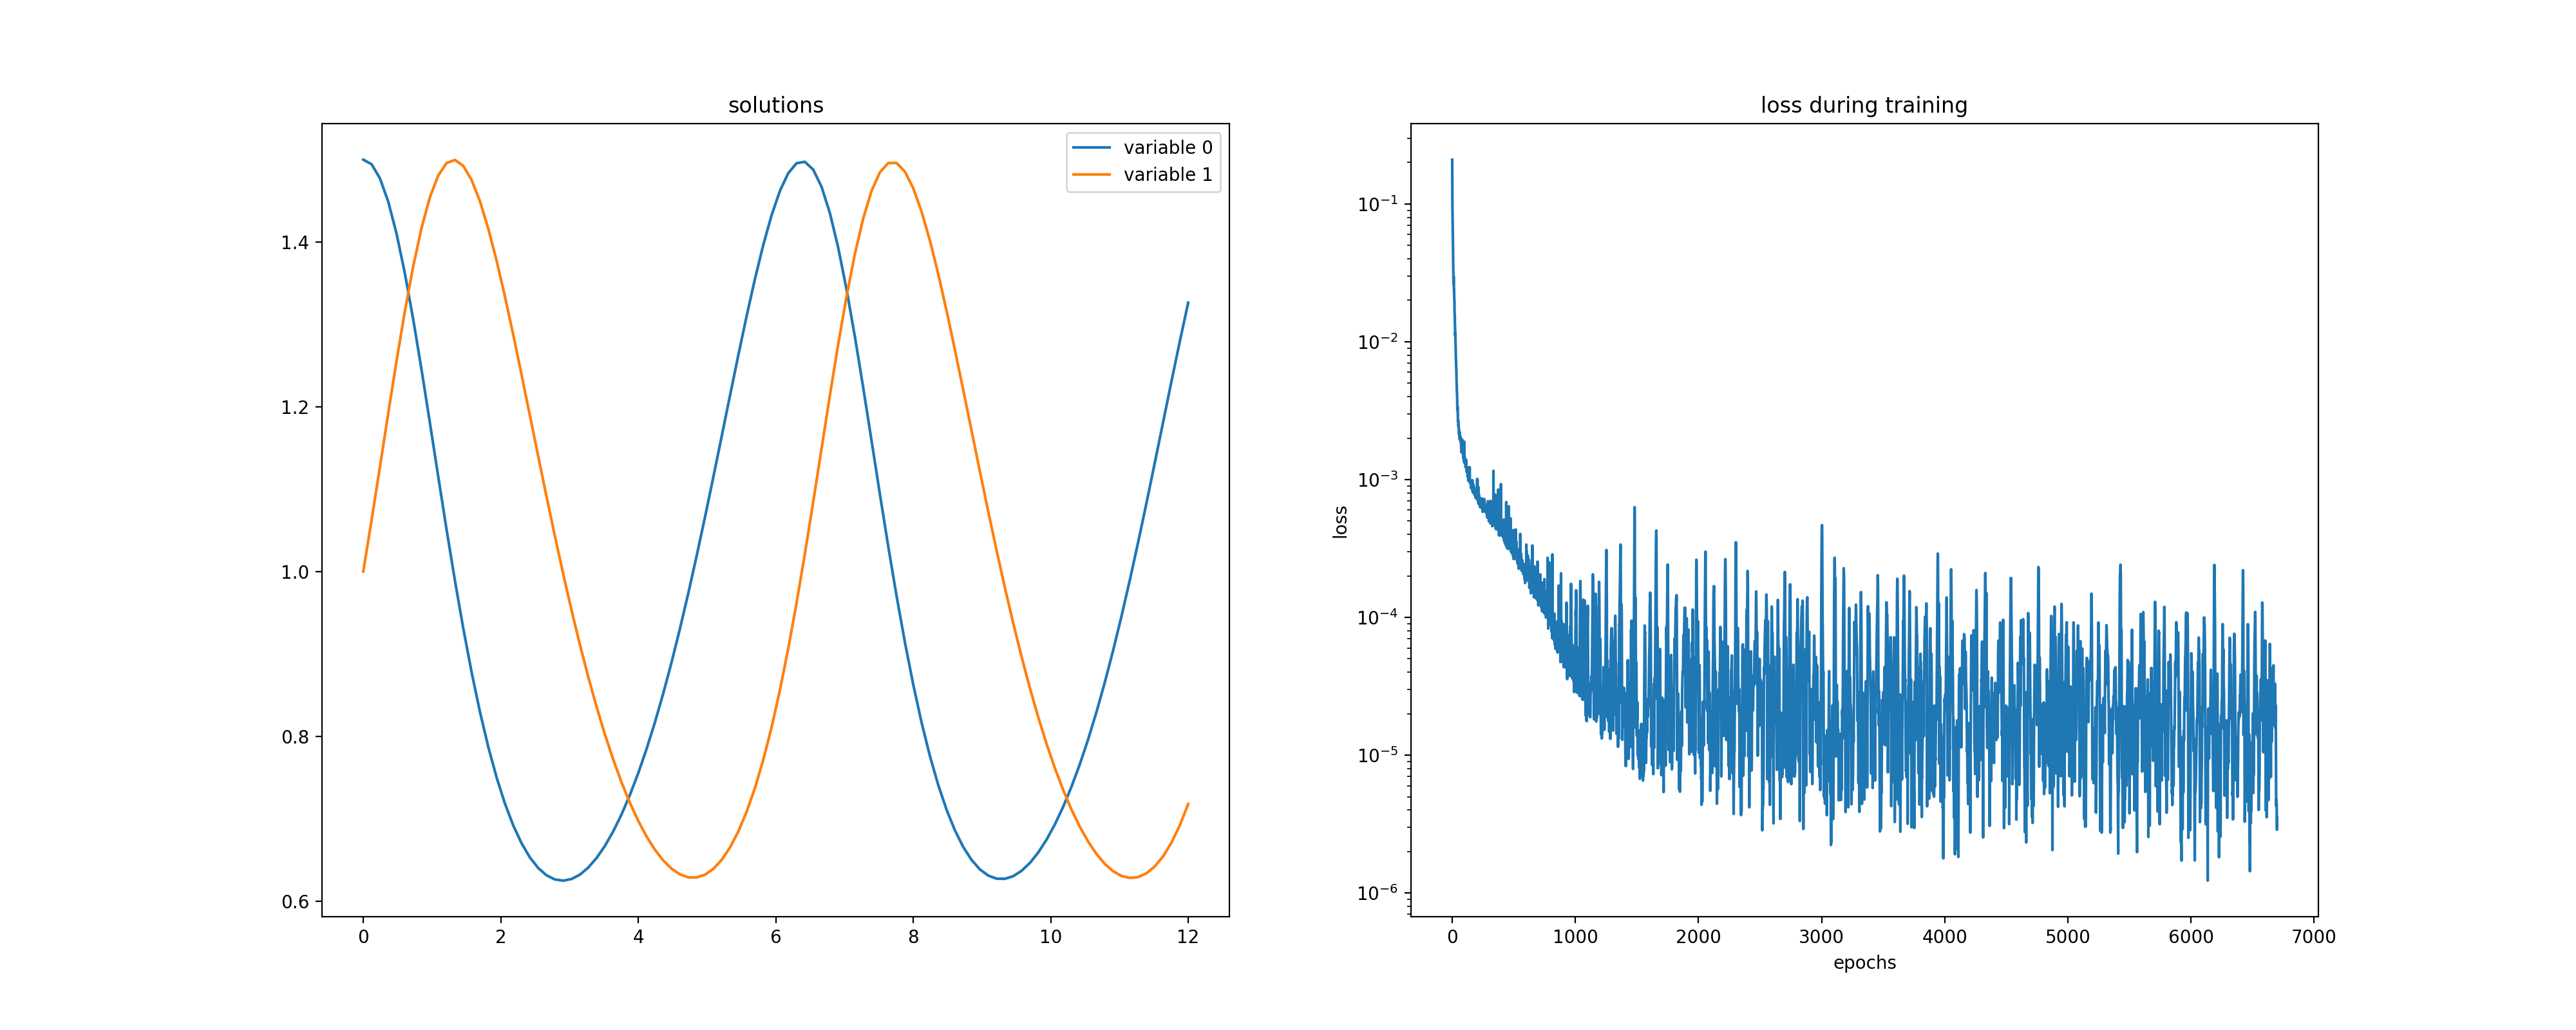

In [15]:
alpha, beta, delta, gamma = 1, 1, 1, 1
lotka_volterra = lambda x, y, t : [diff(x, t) - (alpha*x   - beta*x*y), 
                                   diff(y, t) - (delta*x*y - gamma*y)]
init_vals_lv = [
    InitialValueProblem(t_0=0.0, x_0=1.5),
    InitialValueProblem(t_0=0.0, x_0=1.0)
]
nets_lv = [
    FCNN(n_hidden_units=32, n_hidden_layers=1, actv=SinActv),
    FCNN(n_hidden_units=32, n_hidden_layers=1, actv=SinActv)
]
_, _ = solve_system(ode_system=lotka_volterra, conditions=init_vals_lv, t_min=0.0, t_max=12,
                    nets=nets_lv,
                    tol=1e-6)